# Thí nghiệm 2: Tác động của transfer learning

# Preparation
Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
import shutil

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Path

Tải dữ liệu đã xử lý sẵn trên Google Drive

In [2]:
import os
project_dir = 'Project 1 - CV - Animal Image Classification/'
filter_path = project_dir + 'filtered-name/'
image_path = project_dir + 'animals/'
#os.makedirs(image_path, exist_ok=True)

In [ ]:
folders = [f for f in os.listdir(filter_path) if os.path.isdir(os.path.join(filter_path, f))]
for folder in folders: print(folder, end = ' ')

Downloading...
From: https://drive.google.com/uc?id=1qjjNwm0uISSAWp8AtLfHKqM4pAl_6kVZ
To: e:\Computer Science\Research\AI4E\filtered.zip

  0%|          | 0.00/20.4k [00:00<?, ?B/s]
100%|██████████| 20.4k/20.4k [00:00<00:00, 317kB/s]


african_elephant alpaca american_bison anteater arctic_fox armadillo baboon badger blue_whale brown_bear camel dolphin giraffe groundhog highland_cattle horse jackal kangaroo koala manatee mongoose mountain_goat opossum orangutan otter polar_bear porcupine red_panda rhinoceros seal sea_lion snow_leopard squirrel sugar_glider tapir vampire_bat vicuna walrus warthog water_buffalo weasel wildebeest wombat yak zebra 

In [ ]:
for folder in folders:
  file_path = f'{filter_path}/{folder}/filtered-name.txt'

  with open(file_path, 'r') as file:
    for line in file:
      img = line.strip()
      path_img = f'{image_path}/{folder}/{img}'
      if os.path.exists(path_img):
        os.remove(path_img)
      else:
        print(f"{path_img} del-ed", end=" | ")

## Load data (with augmentation)

In [2]:
image_path = '/content/drive/MyDrive/bé tập Ây Ai/Project 1 - CV - Animal Image Classification/animals'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=512,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_path,
    target_size=(224, 224),
    batch_size=512,
    class_mode='categorical',
    subset='validation'
)

Found 10018 images belonging to 45 classes.
Found 2484 images belonging to 45 classes.


# Khởi tạo mô hình
Thí nghiệm 2: Demonstrate the efficiency of Transfer Learning

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping

## WandB routine

In [ ]:
# import wandb
# wandb.init(project="animals-classifier", entity="letangphuquy4-vietnam-korea-university-of-information-an")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: letangphuquy4 (letangphuquy4-vietnam-korea-university-of-information-an). Use `wandb login --relogin` to force relogin


In [ ]:
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# optimizer = AdamW(learning_rate=1e-4)

# def train_step(x, y, model, optimizer=optimizer, loss_fn=loss_fn, train_acc_metric=train_acc_metric):
#     with tf.GradientTape() as tape:
#         logits = model(x, training=True)
#         loss_value = loss_fn(y, logits)

#     grads = tape.gradient(loss_value, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     train_acc_metric.update_state(y, logits)

#     return loss_value

# def test_step(x, y, model, loss_fn=loss_fn, val_acc_metric=val_acc_metric):
#     val_logits = model(x, training=False)
#     loss_value = loss_fn(y, val_logits)
#     val_acc_metric.update_state(y, val_logits)

#     return loss_value

# def train(train_dataset, val_dataset,  model, optimizer=optimizer,
#           train_acc_metric=train_acc_metric, val_acc_metric=val_acc_metric,
#           epochs=10,  log_step=200, val_log_step=50):

#     for epoch in range(epochs):
#         print("\nStart of epoch %d" % (epoch,))

#         train_loss = []
#         val_loss = []

#         # Iterate over the batches of the dataset
#         for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#             loss_value = train_step(x_batch_train, y_batch_train,
#                                     model, optimizer,
#                                     loss_fn, train_acc_metric)
#             train_loss.append(float(loss_value))

#         # Run a validation loop at the end of each epoch
#         for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
#             val_loss_value = test_step(x_batch_val, y_batch_val,
#                                        model, loss_fn,
#                                        val_acc_metric)
#             val_loss.append(float(val_loss_value))

#         # Display metrics at the end of each epoch
#         train_acc = train_acc_metric.result()
#         print("Training acc over epoch: %.4f" % (float(train_acc),))

#         val_acc = val_acc_metric.result()
#         print("Validation acc: %.4f" % (float(val_acc),))

#         # Reset metrics at the end of each epoch
#         train_acc_metric.reset_states()
#         val_acc_metric.reset_states()

#         # ⭐: log metrics using wandb.log
#         wandb.log({'epochs': epoch,
#                    'loss': np.mean(train_loss),
#                    'acc': float(train_acc),
#                    'val_loss': np.mean(val_loss),
#                    'val_acc':float(val_acc)})

## Helpers

In [10]:

import datetime

from matplotlib import pyplot as plt
import json

def plot_learning_curve(history_dict, name=''):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history_dict['loss'], label='Train Loss')
  plt.plot(history_dict['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history_dict['accuracy'], label='Train Accuracy')
  plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plt.savefig(f'{name}')
  plt.show()

model_path = '/content/drive/MyDrive/bé tập Ây Ai/Project 1 - CV - Animal Image Classification/model and history'
def save_model(model, history_dict, name=''):
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plot_learning_curve(history_dict, name)
  model.save(f'{model_path}/{name}.h5')
  with open(f'{model_path}/history_{name}.json', 'w') as f:
    json.dump(history_dict, f)

# With Transfer Learning

## ResNet50

In [5]:
def create_resnet_model(pretrained=True, lr=1e-3):
    base = ResNet50(weights='imagenet' if pretrained else None, include_top=False, input_shape=(224, 224, 3))
    for layer in base.layers: layer.trainable = False

    model = models.Sequential([
        base,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(45, activation='softmax')
    ])

    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

#resnet_model = create_resnet_model()
#resnet_model.summary()

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
resnet_hist = resnet_model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.0412 - loss: 3.7769 - val_accuracy: 0.0407 - val_loss: 3.7709 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0434 - loss: 3.7683 - val_accuracy: 0.0342 - val_loss: 3.7664 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0441 - loss: 3.7593 - val_accuracy: 0.0507 - val_loss: 3.7506 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0445 - loss: 3.7512 - val_accuracy: 0.0370 - val_loss: 3.7445 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0465 - loss: 3.7429 - val_accuracy: 0.0467 - val_loss: 3.7362 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0465 - loss: 3.7355 - val_accuracy: 0.0439 - val_loss: 3.7351 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0517 - loss: 3.7385 - val_acc

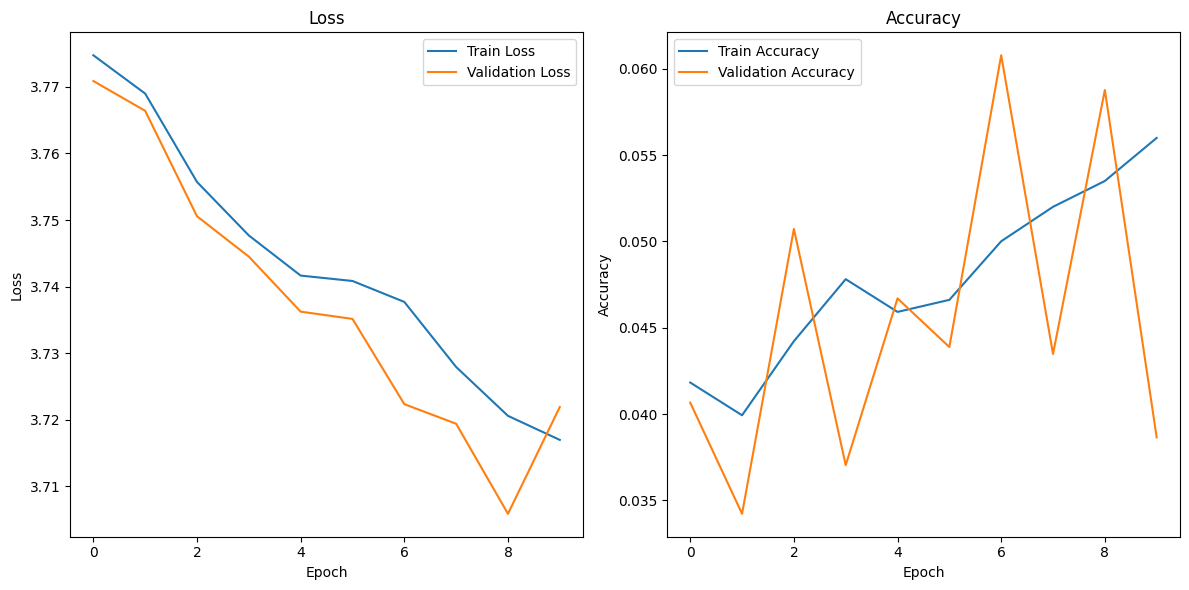

In [11]:
hist = resnet_hist.history
save_model(resnet_model, hist, 'resnet_frozen')

In [12]:
# Mở khóa các lớp mô hình để fine-tuning
for layer in resnet_model.layers[0].layers: layer.trainable = True
resnet_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_hist = resnet_model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.2624 - loss: 4.3594 - val_accuracy: 0.0225 - val_loss: 7.5594
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 6s/step - accuracy: 0.7807 - loss: 0.8461 - val_accuracy: 0.0177 - val_loss: 4.4771
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.8698 - loss: 0.4478 - val_accuracy: 0.0217 - val_loss: 5.1706
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.9058 - loss: 0.3074 - val_accuracy: 0.0225 - val_loss: 5.8190
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.9273 - loss: 0.2274 - val_accuracy: 0.0221 - val_loss: 5.1262


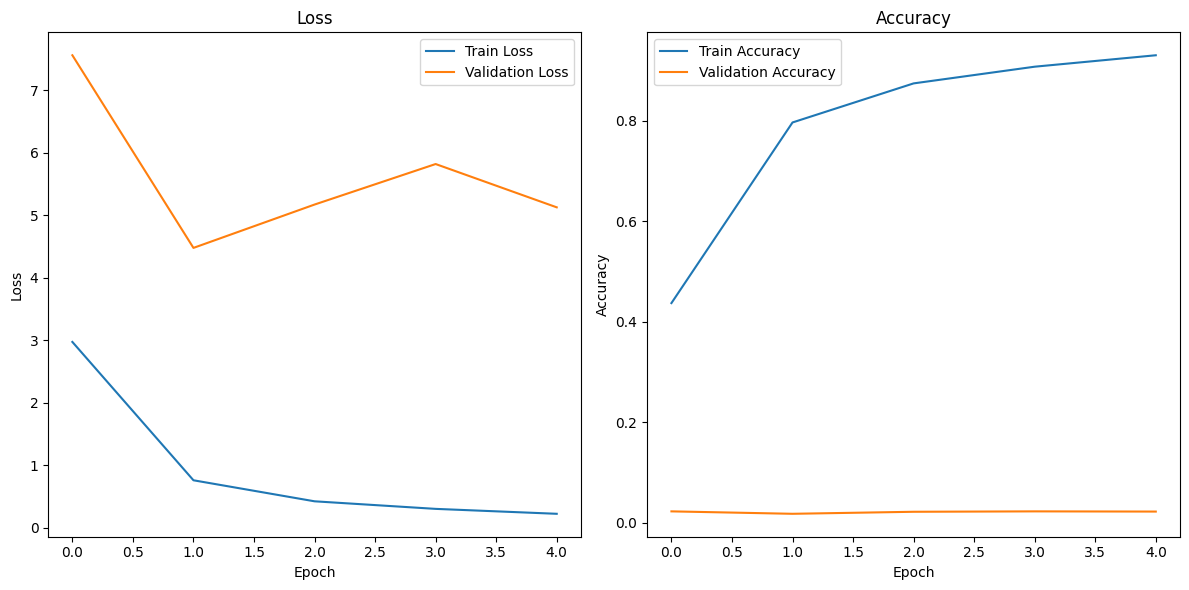

In [13]:
hist = resnet_hist.history
save_model(resnet_model, hist, 'resnet')

## VGG16

In [ ]:

def create_vgg16_model(pretrained=True, lr=1e-3):
    vgg16_base = VGG16(weights='imagenet' if pretrained else None, include_top=False, input_shape=(224, 224, 3))

    for layer in vgg16_base.layers: layer.trainable = False

    vgg_model = models.Sequential([
        vgg16_base,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(45, activation='softmax')
    ])

    vgg_model.compile(optimizer=AdamW(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return vgg_model

#vgg_model = create_vgg16_model()
#vgg_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
VGG16_hist = vgg_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - accuracy: 0.0807 - loss: 3.6823 - val_accuracy: 0.2564 - val_loss: 3.0968
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.3128 - loss: 2.8522 - val_accuracy: 0.3937 - val_loss: 2.5289
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.4557 - loss: 2.3072 - val_accuracy: 0.4670 - val_loss: 2.1953
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.5338 - loss: 1.9538 - val_accuracy: 0.4988 - val_loss: 1.9763
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.5965 - loss: 1.7080 - val_accuracy: 0.5596 - val_loss: 1.7999
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.6420 - loss: 1.5402 - val_accuracy: 0.5733 - val_loss: 1.6817
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.6797 - loss: 1.3758 - val_accuracy: 0.5866 - val_loss: 1.6024
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.6967 - loss: 1.2820 - val

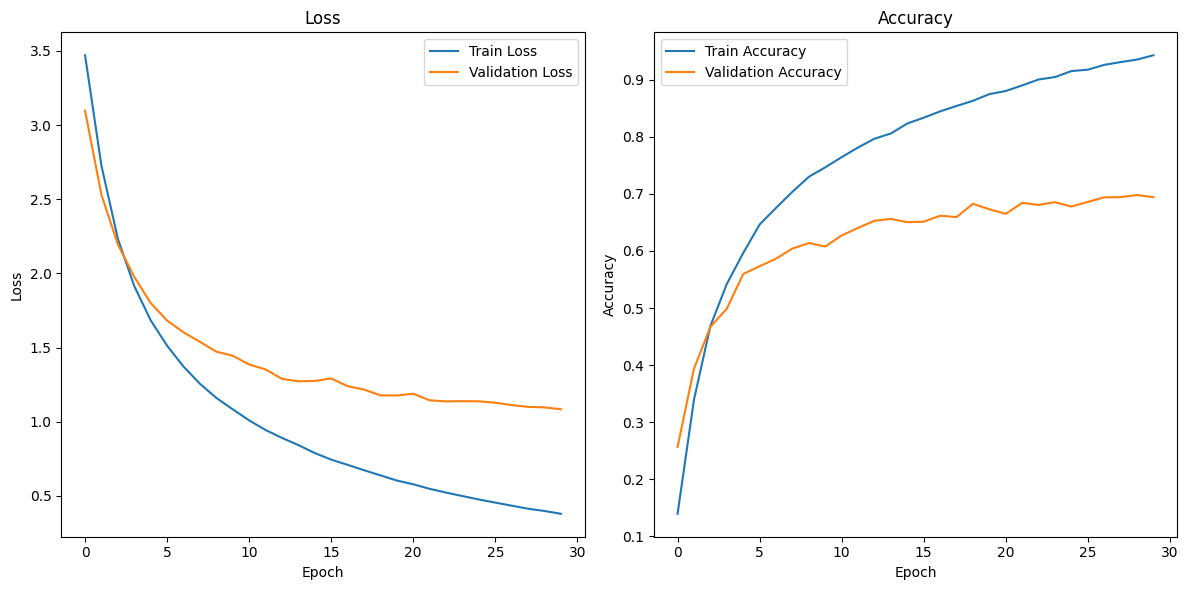

In [ ]:
hist = VGG16_hist.history
# plot_learning_curve(hist)
save_model(vgg_model, hist, 'VGG16_frozen')

In [ ]:
# Mở khóa các lớp mô hình để fine-tuning
for layer in vgg_model.layers[0].layers: layer.trainable = True
vgg_model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
VGG16_hist_fine_tuning = vgg_model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 123s 298ms/step - accuracy: 0.9525 - loss: 0.3172 - val_accuracy: 0.7198 - val_loss: 0.9885
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 278ms/step - accuracy: 0.9550 - loss: 0.2615 - val_accuracy: 0.7230 - val_loss: 0.9719
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 277ms/step - accuracy: 0.9574 - loss: 0.2398 - val_accuracy: 0.7246 - val_loss: 0.9664
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.9582 - loss: 0.2224 - val_accuracy: 0.7267 - val_loss: 0.9653
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 278ms/step - accuracy: 0.9573 - loss: 0.2139 - val_accuracy: 0.7250 - val_loss: 0.9656
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 276ms/step - accuracy: 0.9575 - loss: 0.2104 - val_accuracy: 0.7238 - val_loss: 0.9683
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.9573 - loss: 0.1997 - val_accuracy: 0.7234 - val_loss: 0.9703
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 87s 275ms/step - accuracy: 0.9632 - loss: 

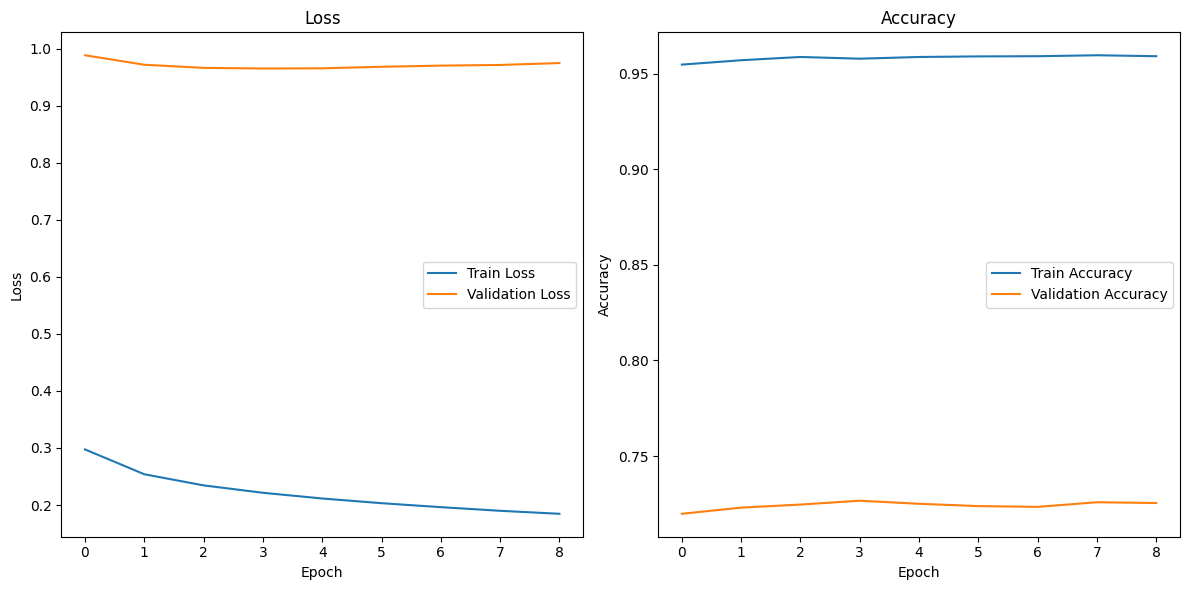

In [ ]:
hist = VGG16_hist_fine_tuning.history
plot_learning_curve(hist)
save_model(vgg_model, hist, 'VGG16')

# Without Transfer Learning
aka. Training from Scratch

## VGG16

In [ ]:
vgg_model = create_vgg16_model(pretrained=False, lr=1e-4)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
VGG16_hist = vgg_model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 7s/step - accuracy: 0.0250 - loss: 3.8061 - val_accuracy: 0.0246 - val_loss: 3.8041
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 6s/step - accuracy: 0.0257 - loss: 3.8035 - val_accuracy: 0.0246 - val_loss: 3.8017
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0220 - loss: 3.8012 - val_accuracy: 0.0282 - val_loss: 3.7994
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0288 - loss: 3.7991 - val_accuracy: 0.0270 - val_loss: 3.7975
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0264 - loss: 3.7977 - val_accuracy: 0.0270 - val_loss: 3.7959
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0227 - loss: 3.7962 - val_accuracy: 0.0270 - val_loss: 3.7947
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0277 - loss: 3.7931 - val_accuracy: 0.0270 - val_loss: 3.7932
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0288 - loss: 3.7922 - val_accuracy: 0.0270 - v

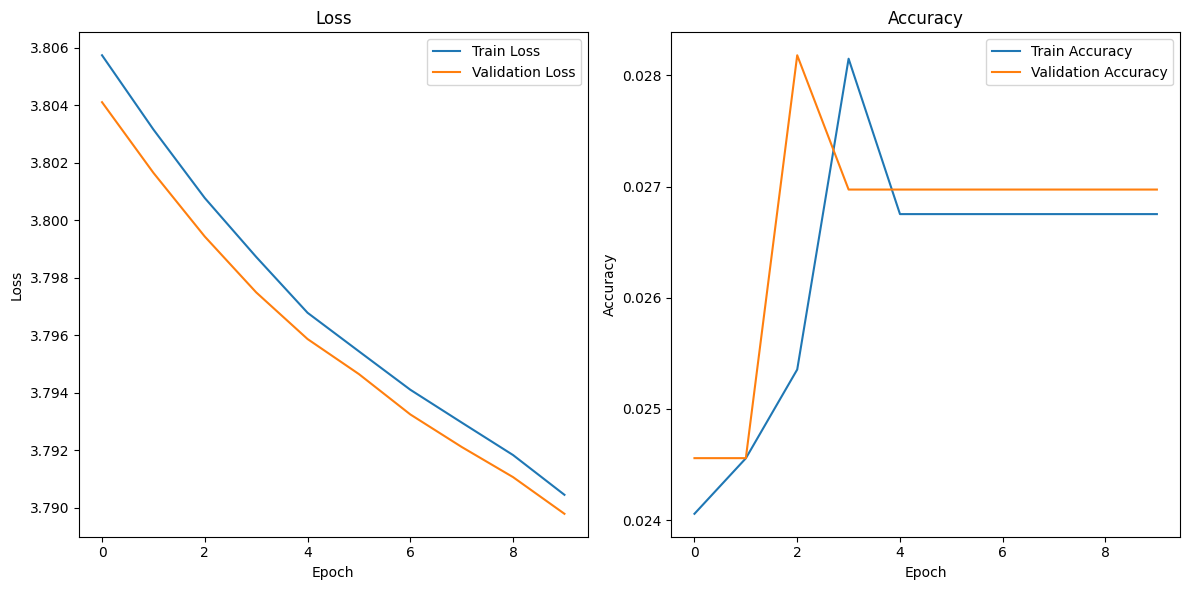

In [ ]:
hist = VGG16_hist.history
save_model(vgg_model, hist, 'VGG16_scratch')

## ResNet50

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
resnet_model = create_resnet_model(pretrained=False, lr=1e-4)
resnet_hist = resnet_model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 221s 8s/step - accuracy: 0.0196 - loss: 3.8082 - val_accuracy: 0.0177 - val_loss: 3.8079 - learning_rate: 1.0000e-04
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0183 - loss: 3.8076 - val_accuracy: 0.0177 - val_loss: 3.8077 - learning_rate: 1.0000e-04
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0186 - loss: 3.8073 - val_accuracy: 0.0173 - val_loss: 3.8071 - learning_rate: 1.0000e-04
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.0206 - loss: 3.8064 - val_accuracy: 0.0290 - val_loss: 3.8059 - learning_rate: 1.0000e-04
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.0260 - loss: 3.8065 - val_accuracy: 0.0318 - val_loss: 3.8056 - learning_rate: 1.0000e-04


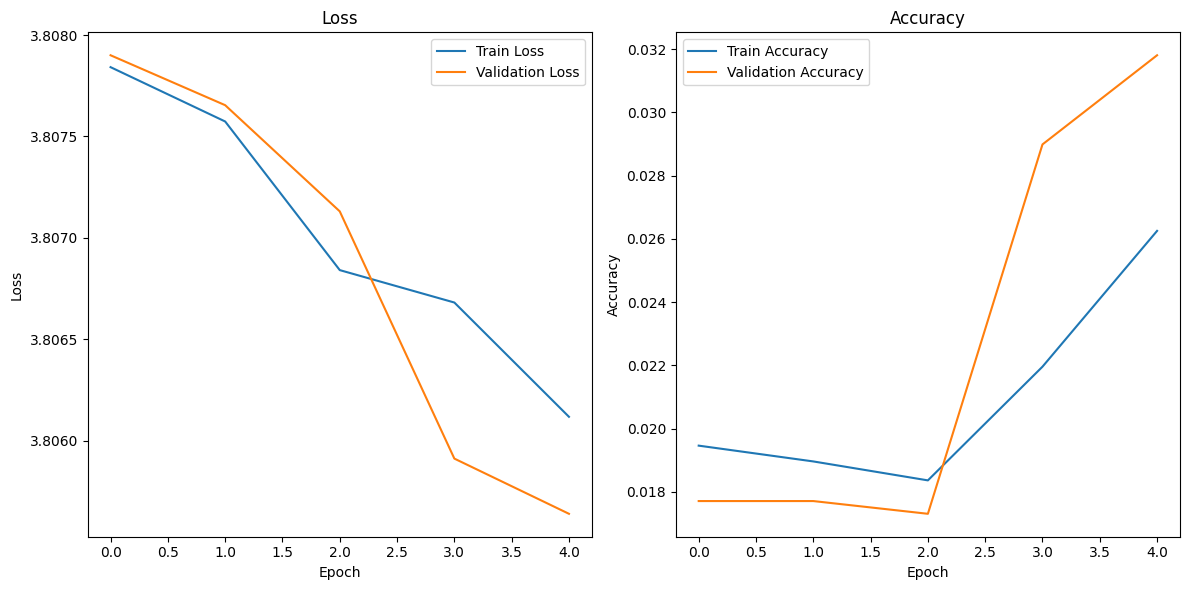

In [11]:
hist = resnet_hist.history
save_model(resnet_model, hist, 'resnet_scratch')